In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Load the pickled working dataset obtained from data_extraction.ipynb.

In [ ]:
def getfile(f, **kwargs):
  loc = 'https://drive.google.com/uc?export=download&id='+f.split('/')[-2]
  out = pd.read_pickle(loc, **kwargs)
  return out

# working dataset
f = "https://drive.google.com/file/d/1pltF9KHbAy4UPCin6W_qI317A6-xaCdT/view?usp=drive_link"
# debugging dataset
# f = "https://drive.google.com/file/d/1-6Pd1y-O0LzcpzSy1VPONV2ASD7WmAPS/view?usp=drive_link"
df = getfile(f)
df.head()

,Area Name,Area Type,Year,Month,Date_Numeric,Seasonally Adjusted(Y/N),Status,Labor Force,Employment,Unemployment,Unemployment Rate,Benchmark
0,California,State,1976,January,1976-01-01,N,Final,9672362,8668016,1004346,10.4,2020
1,California,State,1976,January,1976-01-01,Y,Final,9774280,8875685,898595,9.2,2020
2,California,State,1976,February,1976-02-01,N,Final,9684440,8704564,979876,10.1,2020
3,California,State,1976,February,1976-02-01,Y,Final,9768885,8871553,897332,9.2,2020
4,California,State,1976,March,1976-03-01,N,Final,9689626,8776344,913282,9.4,2020


Convert DateTime objects to float values.

In [ ]:
df['Date'] = df['Date_Numeric'].dt.to_period('M')
df['Date'] = df['Date'].dt.to_timestamp().apply(lambda x : pd.Timestamp(x).to_julian_date())
df.head()

,Area Name,Area Type,Year,Month,Date_Numeric,Seasonally Adjusted(Y/N),Status,Labor Force,Employment,Unemployment,Unemployment Rate,Benchmark,Date
0,California,State,1976,January,1976-01-01,N,Final,9672362,8668016,1004346,10.4,2020,2442778.5
1,California,State,1976,January,1976-01-01,Y,Final,9774280,8875685,898595,9.2,2020,2442778.5
2,California,State,1976,February,1976-02-01,N,Final,9684440,8704564,979876,10.1,2020,2442809.5
3,California,State,1976,February,1976-02-01,Y,Final,9768885,8871553,897332,9.2,2020,2442809.5
4,California,State,1976,March,1976-03-01,N,Final,9689626,8776344,913282,9.4,2020,2442838.5


Drop redundant columns.

In [ ]:
df.drop(['Year', 'Month', 'Date_Numeric'], axis='columns', inplace=True)
df.head()

,Area Name,Area Type,Seasonally Adjusted(Y/N),Status,Labor Force,Employment,Unemployment,Unemployment Rate,Benchmark,Date
0,California,State,N,Final,9672362,8668016,1004346,10.4,2020,2442778.5
1,California,State,Y,Final,9774280,8875685,898595,9.2,2020,2442778.5
2,California,State,N,Final,9684440,8704564,979876,10.1,2020,2442809.5
3,California,State,Y,Final,9768885,8871553,897332,9.2,2020,2442809.5
4,California,State,N,Final,9689626,8776344,913282,9.4,2020,2442838.5


Convert categorical variables to numerical values. Drop one dummy variable in each category to prevent multicollinearity.

In [ ]:
categorical_cols = ['Area Name', 'Area Type', 'Seasonally Adjusted(Y/N)', 'Status', 'Benchmark']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df.head()

,Labor Force,Employment,Unemployment,Unemployment Rate,Date,Area Name_Adelanto city,Area Name_Agoura Hills city,Area Name_Alameda County,Area Name_Alameda city,Area Name_Alamo CDP,...,Area Name_Yuba County,Area Name_Yucaipa city,Area Name_Yucca Valley town,Area Type_Metropolitan Area,Area Type_State,Area Type_Sub-County Place,Seasonally Adjusted(Y/N)_Y,Status_Preliminary,Benchmark_2021,Benchmark_2023
0,9672362,8668016,1004346,10.4,2442778.5,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,9774280,8875685,898595,9.2,2442778.5,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,False
2,9684440,8704564,979876,10.1,2442809.5,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,9768885,8871553,897332,9.2,2442809.5,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,False
4,9689626,8776344,913282,9.4,2442838.5,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [ ]:
df.shape

(204096, 1032)

In [ ]:
X = df.drop('Unemployment Rate', axis=1).values
y = df['Unemployment Rate'].values

#Scaling feature
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Prepare sequential data
timesteps = 1
X_seq = X.reshape((X.shape[0], timesteps, X.shape[1]))

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: torch.Size([163276, 1, 1031])
X_test shape: torch.Size([40820, 1, 1031])
y_train shape: torch.Size([163276, 1])
y_test shape: torch.Size([40820, 1])


# Investigate effects of mini-batch learning

In [ ]:
# Build the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(RNNModel, self).__init__()
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), hidden_size, device=x.device)  # Initial hidden state
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Fully connected layer on the last time step
        return out

In [ ]:
from tqdm import tqdm

# Training
def train(model, trainloader, valloader, criterion, optimizer, epochs=100, device="cpu"):
    """
    Train the model with the given data and optimizer.

    Args:
        model: The model to train.
        trainloader: DataLoader for the training set.
        valloader: DataLoader for the validation set.
        criterion: Loss function.
        optimizer: Optimizer.
        epochs: Number of training epochs (default: 100).
        device: Device to run the training on (e.g., 'cpu' or 'cuda').

    Returns:
        history: Dictionary with 'train_loss' and 'val_loss' over epochs.
    """
    history = {"train_loss": [], "val_loss": []}

    model.to(device)  # Ensure the model is on the correct device

    # Create a single tqdm progress bar for all epochs
    with tqdm(total=epochs, desc="Training Progress", unit="epoch") as epoch_pbar:
        for epoch in range(epochs):
            model.train()  # Set model to training mode
            train_loss = 0.0

            # Training loop
            for inputs, labels in trainloader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to device

                # Zero gradients
                optimizer.zero_grad()

                if isinstance(optimizer, torch.optim.LBFGS):
                    # Define closure function for LBFGS
                    def closure():
                        optimizer.zero_grad()
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        return loss

                    loss = optimizer.step(closure)
                else:
                    # Standard optimization step for other optimizers
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                train_loss += loss.item()

            train_loss /= len(trainloader)
            history["train_loss"].append(train_loss)

            # Validation loop
            model.eval()  # Set model to evaluation mode
            val_loss = 0.0
            with torch.no_grad():
                for inputs, labels in valloader:
                    inputs, labels = inputs.to(device), labels.to(device)  # Move data to device

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

            val_loss /= len(valloader)
            history["val_loss"].append(val_loss)

            # Update the progress bar after each epoch
            epoch_pbar.set_postfix({"Train Loss": train_loss, "Val Loss": val_loss})
            epoch_pbar.update(1)

    return history

In [ ]:
def eval(model, testloader, device="cpu"):
    """
    Evaluate the model on the test set.

    Args:
        model: The trained model to evaluate.
        testloader: DataLoader for the test set.
        device: Device to run the evaluation on (e.g., 'cpu' or 'cuda').

    Returns:
        Tuple containing average MSE loss, MAE loss, and R2 score.
    """
    model.eval()  # Set model to evaluation mode
    model.to(device)  # Ensure the model is on the correct device
    mse_loss = 0.0
    mae_loss = 0.0
    r2 = 0.0

    # Initialize metrics
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    with torch.no_grad():
        for inputs, labels in testloader:
            # Move inputs and labels to the specified device
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Move outputs and labels back to the CPU for metric calculation
            outputs = outputs.cpu().numpy()
            labels = labels.cpu().numpy()

            # Calculate metrics
            mse_loss += mean_squared_error(labels, outputs)
            mae_loss += mean_absolute_error(labels, outputs)
            r2 += r2_score(labels, outputs)

    # Compute average metrics
    return mse_loss / len(testloader), mae_loss / len(testloader), r2 / len(testloader)

In [ ]:
input_size = X_seq.shape[2]  # Number of features
hidden_size = 100  # Number of RNN units
output_size = 1  # Predicting a single value (unemployment rate)

In [ ]:
# Split into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: torch.Size([130620, 1, 1031])
X_test shape: torch.Size([40820, 1, 1031])
y_train shape: torch.Size([130620, 1])
y_test shape: torch.Size([40820, 1])


# Investigate the effects of different optimizers
We test it with four different types of optimizers. Our selection is based on
the algorithmic design for different purposes of optimization. These include the
following:


*   SGD : Most naive baseline where it approximates the gradient using expectation of the samples.
*   AdaGrad: It possess the additional features of adaptive learning rate
*   ADAM: It uses the previous gradient history to take a effective steps.
*   L-BFGS: It is second-order quasi Newton method that approximates the inverse Hessian of the score function. It is effective at capturing the optimization landscape.



In [ ]:
import torch

### Additional features ###
# Test with different optimizers instead of varying batch sizes
lr = 0.005
optimizers = {
    "SGD": lambda params: optim.SGD(params, lr=lr, momentum=0.9),
    "Adagrad": lambda params: optim.Adagrad(params, lr=lr),
    "Adam": lambda params: optim.Adam(params, lr=lr),
    "LBFGS": lambda params: optim.LBFGS(params, lr=lr, history_size=10, max_iter=5, line_search_fn="strong_wolfe"),

}

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Fixed batch size
batch_size = 1024
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


histories = []

mse_loss_list = []
mae_loss_list = []
r2_score_list = []

for opt_name, opt_fn in optimizers.items():
    print(f"\nTesting with optimizer: {opt_name}")

    # Initialize the model and move it to the GPU
    model = RNNModel(input_size, hidden_size, output_size).to(device)
    criterion = nn.MSELoss()
    optimizer = opt_fn(model.parameters())

    # Train the model
    history = train(model, trainloader, valloader, criterion, optimizer, epochs=100, device=device)
    histories.append(history)

    # Evaluate the model
    mse_loss, mae_loss, r2 = eval(model, testloader, device=device)
    print(f"{opt_name} | MSE Loss: {mse_loss:.4f}, MAE Loss: {mae_loss:.4f}, R2 Score: {r2:.4f}")

    mse_loss_list.append(mse_loss)
    mae_loss_list.append(mae_loss)
    r2_score_list.append(r2)


Using device: cpu

Testing with optimizer: SGD


Training Progress: 100%|██████████| 100/100 [08:15<00:00,  4.95s/epoch, Train Loss=3.48, Val Loss=3.81]


SGD | MSE Loss: 3.6458, MAE Loss: 1.0184, R2 Score: 0.9315

Testing with optimizer: Adagrad


Training Progress: 100%|██████████| 100/100 [07:57<00:00,  4.78s/epoch, Train Loss=6.83, Val Loss=7.09]


Adagrad | MSE Loss: 6.8456, MAE Loss: 1.3026, R2 Score: 0.8771

Testing with optimizer: Adam


Training Progress: 100%|██████████| 100/100 [08:05<00:00,  4.85s/epoch, Train Loss=3.13, Val Loss=3.54]


Adam | MSE Loss: 3.5043, MAE Loss: 1.0591, R2 Score: 0.9339

Testing with optimizer: LBFGS


Training Progress: 100%|██████████| 100/100 [37:40<00:00, 22.60s/epoch, Train Loss=4.49, Val Loss=4.79]


LBFGS | MSE Loss: 4.8098, MAE Loss: 1.3428, R2 Score: 0.9091


# Optimizer Comparison

SGD:

Fast convergence: After 100 epochs, Train Loss = 3.48, Val Loss = 3.81.
good performance: MSE = 3.64, MAE = 1.02, R² = 0.93.
Suitable for this task due to faster and more effective optimization.

Adagrad:

SLow convergence: After 100 epochs, Train Loss = 6.83, Val Loss = 7.09.
Weak performance: Both training and validation losses decrease consistently.
Better performance: MSE = 6.85, MAE = 1.30, R² = 0.88.

Adam:

Fastest convergence: Train Loss = 3.13, Val Loss = 3.54 at 100 epochs.
Best performance: MSE = 3.5, MAE = 1.06, R² = 0.93.
Ideal choice for this task due to its speed and accuracy.

L-BFGS:

Fast convergence: After 100 epochs, Train Loss = 4.49, Val Loss = 4.79.
Weak stability: Validation loss is unstable as others are consistent curve.
Better performance: MSE = 4.81, MAE = 1.34, R² = 0.91.

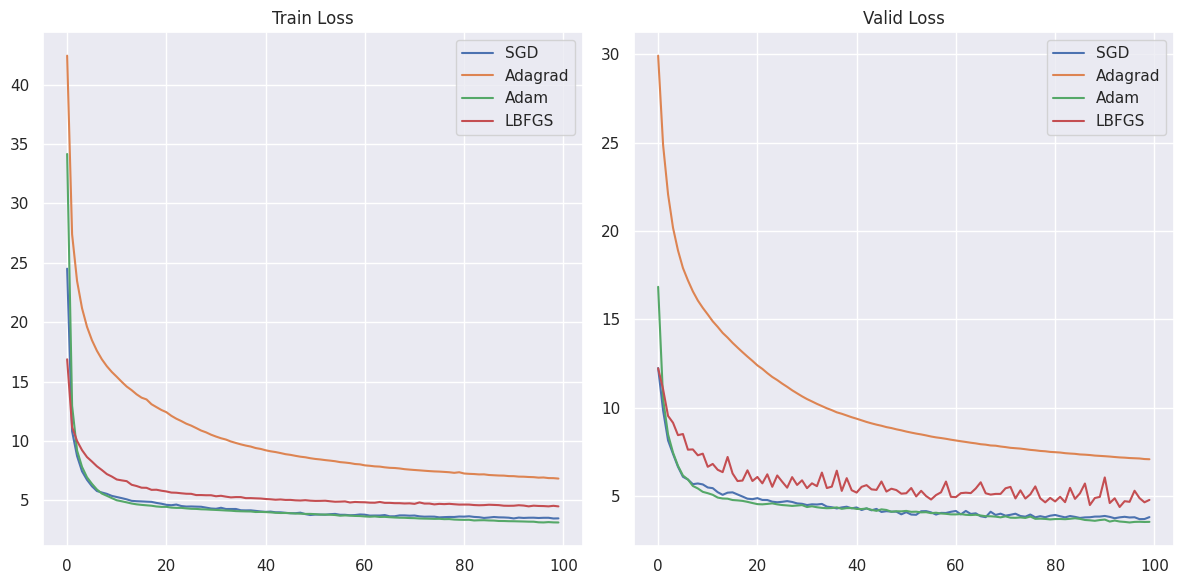

In [ ]:
import seaborn as sns
sns.set_theme()

# Example data (replace these with your actual lists)
optimizers = ["SGD", "Adagrad", "Adam", "LBFGS"]  # Replace with actual optimizer names

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for opt_name, history in zip(optimizers, histories):
  axes[0].plot(history['train_loss'], label=opt_name)
  axes[1].plot(history['val_loss'], label=opt_name)

# Adjust layout
axes[0].set_title("Train Loss")
axes[0].legend()
axes[1].set_title("Valid Loss")
axes[1].legend()
plt.tight_layout()
plt.show()

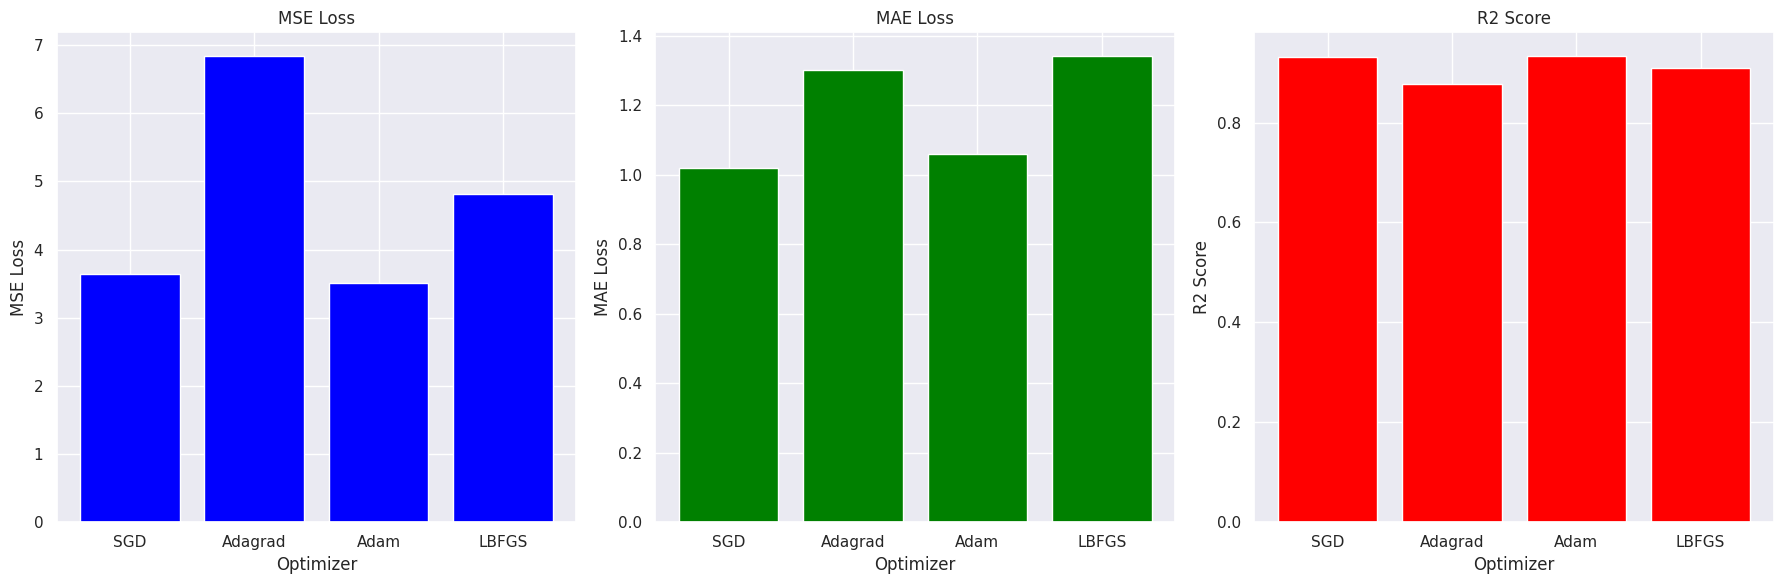

In [ ]:
# Example data (replace these with your actual lists)
optimizers = ["SGD", "Adagrad", "Adam", "LBFGS"]  # Replace with actual optimizer names

# Create subplots for each metric
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot MSE Loss
axes[0].bar(optimizers, mse_loss_list, color='blue')
axes[0].set_title('MSE Loss')
axes[0].set_xlabel('Optimizer')
axes[0].set_ylabel('MSE Loss')

# Plot MAE Loss
axes[1].bar(optimizers, mae_loss_list, color='green')
axes[1].set_title('MAE Loss')
axes[1].set_xlabel('Optimizer')
axes[1].set_ylabel('MAE Loss')

# Plot R2 Score
axes[2].bar(optimizers, r2_score_list, color='red')
axes[2].set_title('R2 Score')
axes[2].set_xlabel('Optimizer')
axes[2].set_ylabel('R2 Score')

# Adjust layout
plt.tight_layout()
plt.show()

debugging dataset results:

In [ ]:
# Batch size: 16
# Epoch [10/100], Train Loss: 14.8161, Val Loss: 18.7288
# Epoch [20/100], Train Loss: 9.2154, Val Loss: 14.9320
# Epoch [30/100], Train Loss: 8.4547, Val Loss: 14.3672
# Epoch [40/100], Train Loss: 7.1126, Val Loss: 14.1257
# Epoch [50/100], Train Loss: 6.4145, Val Loss: 13.5924
# Epoch [60/100], Train Loss: 6.3400, Val Loss: 14.5617
# Epoch [70/100], Train Loss: 6.4920, Val Loss: 14.5393
# Epoch [80/100], Train Loss: 5.9553, Val Loss: 14.2768
# Epoch [90/100], Train Loss: 5.8614, Val Loss: 14.5257
# Epoch [100/100], Train Loss: 5.6932, Val Loss: 14.3241
# MSE Loss: 13.7916, MAE Loss: 2.4647, R2 Score: 0.5652

# Batch size: 32
# Epoch [10/100], Train Loss: 17.2399, Val Loss: 20.2217
# Epoch [20/100], Train Loss: 10.5658, Val Loss: 18.4745
# Epoch [30/100], Train Loss: 8.7186, Val Loss: 17.1227
# Epoch [40/100], Train Loss: 7.1616, Val Loss: 16.5705
# Epoch [50/100], Train Loss: 6.8027, Val Loss: 15.7319
# Epoch [60/100], Train Loss: 6.5712, Val Loss: 14.4860
# Epoch [70/100], Train Loss: 6.2304, Val Loss: 15.2795
# Epoch [80/100], Train Loss: 6.0181, Val Loss: 14.8353
# Epoch [90/100], Train Loss: 5.6856, Val Loss: 14.9839
# Epoch [100/100], Train Loss: 5.5782, Val Loss: 14.7466
# MSE Loss: 12.3669, MAE Loss: 2.3996, R2 Score: 0.6821

# Batch size: 64
# Epoch [10/100], Train Loss: 16.6986, Val Loss: 23.2086
# Epoch [20/100], Train Loss: 11.0081, Val Loss: 20.6856
# Epoch [30/100], Train Loss: 8.5959, Val Loss: 17.4249
# Epoch [40/100], Train Loss: 7.3881, Val Loss: 17.3612
# Epoch [50/100], Train Loss: 6.7308, Val Loss: 17.5548
# Epoch [60/100], Train Loss: 6.3915, Val Loss: 16.2184
# Epoch [70/100], Train Loss: 6.1516, Val Loss: 14.6982
# Epoch [80/100], Train Loss: 6.0675, Val Loss: 14.5730
# Epoch [90/100], Train Loss: 5.6434, Val Loss: 13.9260
# Epoch [100/100], Train Loss: 5.6314, Val Loss: 14.0449
# MSE Loss: 12.6617, MAE Loss: 2.4116, R2 Score: 0.7172

# Batch size: 128
# Epoch [10/100], Train Loss: 17.6243, Val Loss: 20.0473
# Epoch [20/100], Train Loss: 11.3208, Val Loss: 17.4686
# Epoch [30/100], Train Loss: 8.4845, Val Loss: 17.4926
# Epoch [40/100], Train Loss: 7.0569, Val Loss: 16.3902
# Epoch [50/100], Train Loss: 6.3206, Val Loss: 15.9952
# Epoch [60/100], Train Loss: 5.9333, Val Loss: 15.0235
# Epoch [70/100], Train Loss: 5.6925, Val Loss: 15.4825
# Epoch [80/100], Train Loss: 5.4707, Val Loss: 15.1774
# Epoch [90/100], Train Loss: 5.4996, Val Loss: 15.0551
# Epoch [100/100], Train Loss: 5.0639, Val Loss: 14.7310
# MSE Loss: 12.3878, MAE Loss: 2.3256, R2 Score: 0.7457

**Different Learning Rate with Optimizer Adam**

In [ ]:
# Define learning rates to test
learning_rates = [0.0001, 0.001, 0.005, 0.01, 0.05]

# Choose optimizer (e.g., Adam or SGD)
optimizer_name = "Adam"  # Change to "SGD" for testing SGD
optimizer_fn = lambda params, lr: optim.Adam(params, lr=lr) if optimizer_name == "Adam" else optim.SGD(params, lr=lr, momentum=0.9)

mse_loss_list = []
mae_loss_list = []
r2_score_list = []

# Test with different learning rates
for lr in learning_rates:
    print(f"\nTesting with learning rate: {lr}, Optimizer: {optimizer_name}")

    # Initialize model and optimizer
    model = RNNModel(input_size, hidden_size, output_size).to(device)
    criterion = nn.MSELoss()
    optimizer = optimizer_fn(model.parameters(), lr)

    # Train the model
    train(model, trainloader, valloader, criterion, optimizer, epochs=100, device=device)

    # Evaluate the model
    mse_loss, mae_loss, r2 = eval(model, testloader, device=device)
    print(f"MSE Loss: {mse_loss:.4f}, MAE Loss: {mae_loss:.4f}, R2 Score: {r2:.4f}")

    # Log results
    mse_loss_list.append(mse_loss)
    mae_loss_list.append(mae_loss)
    r2_score_list.append(r2)




Testing with learning rate: 0.0001, Optimizer: Adam
Epoch [10/100], Train Loss: 7.4530, Val Loss: 7.4718
Epoch [20/100], Train Loss: 5.2080, Val Loss: 5.3311


In [ ]:
# Testing with learning rate: 0.0001, Optimizer: Adam
# Epoch [10/100], Train Loss: 7.4530, Val Loss: 7.4718
# Epoch [20/100], Train Loss: 5.2080, Val Loss: 5.3311
# Epoch [30/100], Train Loss: 4.3968, Val Loss: 4.5836
# Epoch [40/100], Train Loss: 4.0077, Val Loss: 4.2255
# Epoch [50/100], Train Loss: 3.7889, Val Loss: 3.9999
# Epoch [60/100], Train Loss: 3.6183, Val Loss: 3.9019
# Epoch [70/100], Train Loss: 3.4729, Val Loss: 3.7066
# Epoch [80/100], Train Loss: 3.3594, Val Loss: 3.6008
# Epoch [90/100], Train Loss: 3.2603, Val Loss: 3.5022
# Epoch [100/100], Train Loss: 3.1635, Val Loss: 3.3930
# MSE Loss: 3.3653, MAE Loss: 0.9861, R2 Score: 0.9180

# Testing with learning rate: 0.001, Optimizer: Adam
# Epoch [10/100], Train Loss: 4.5475, Val Loss: 4.7598
# Epoch [20/100], Train Loss: 4.0338, Val Loss: 4.2970
# Epoch [30/100], Train Loss: 3.7778, Val Loss: 3.9836
# Epoch [40/100], Train Loss: 3.5874, Val Loss: 3.8396
# Epoch [50/100], Train Loss: 3.4377, Val Loss: 3.6847
# Epoch [60/100], Train Loss: 3.3262, Val Loss: 3.6182
# Epoch [70/100], Train Loss: 3.2425, Val Loss: 3.5004
# Epoch [80/100], Train Loss: 3.1726, Val Loss: 3.4715
# Epoch [90/100], Train Loss: 3.1141, Val Loss: 3.4061
# Epoch [100/100], Train Loss: 3.0694, Val Loss: 3.3426
# MSE Loss: 3.3376, MAE Loss: 1.0266, R2 Score: 0.9184

# Testing with learning rate: 0.005, Optimizer: Adam
# Epoch [10/100], Train Loss: 5.5541, Val Loss: 5.6084
# Epoch [20/100], Train Loss: 5.1262, Val Loss: 5.3651
# Epoch [30/100], Train Loss: 4.8576, Val Loss: 5.0573
# Epoch [40/100], Train Loss: 4.7244, Val Loss: 4.9147
# Epoch [50/100], Train Loss: 4.5876, Val Loss: 4.8504
# Epoch [60/100], Train Loss: 4.5057, Val Loss: 4.8317
# Epoch [70/100], Train Loss: 4.3975, Val Loss: 4.6241
# Epoch [80/100], Train Loss: 4.2958, Val Loss: 4.5737
# Epoch [90/100], Train Loss: 4.2254, Val Loss: 4.4739
# Epoch [100/100], Train Loss: 4.2001, Val Loss: 4.4101
# MSE Loss: 4.2827, MAE Loss: 1.2668, R2 Score: 0.8940

# Testing with learning rate: 0.01, Optimizer: Adam
# Epoch [10/100], Train Loss: 6.4509, Val Loss: 6.5102
# Epoch [20/100], Train Loss: 5.7986, Val Loss: 6.0810
# Epoch [30/100], Train Loss: 5.4978, Val Loss: 5.7403
# Epoch [40/100], Train Loss: 5.2817, Val Loss: 5.5880
# Epoch [50/100], Train Loss: 5.2234, Val Loss: 5.3963
# Epoch [60/100], Train Loss: 5.0821, Val Loss: 5.2713
# Epoch [70/100], Train Loss: 5.0262, Val Loss: 5.2662
# Epoch [80/100], Train Loss: 4.9095, Val Loss: 5.2764
# Epoch [90/100], Train Loss: 4.8447, Val Loss: 5.0507
# Epoch [100/100], Train Loss: 4.8151, Val Loss: 5.0404
# MSE Loss: 4.9786, MAE Loss: 1.4227, R2 Score: 0.8753

# Testing with learning rate: 0.05, Optimizer: Adam
# Epoch [10/100], Train Loss: 10.9064, Val Loss: 10.4687
# Epoch [20/100], Train Loss: 9.4593, Val Loss: 9.4482
# Epoch [30/100], Train Loss: 9.0091, Val Loss: 9.4245
# Epoch [40/100], Train Loss: 8.4451, Val Loss: 8.6020
# Epoch [50/100], Train Loss: 8.1967, Val Loss: 8.3822
# Epoch [60/100], Train Loss: 7.9738, Val Loss: 8.1206
# Epoch [70/100], Train Loss: 7.9164, Val Loss: 8.1256
# Epoch [80/100], Train Loss: 7.7601, Val Loss: 7.8883
# Epoch [90/100], Train Loss: 7.8502, Val Loss: 8.2441
# Epoch [100/100], Train Loss: 7.6471, Val Loss: 8.0770
# MSE Loss: 7.8593, MAE Loss: 1.9972, R2 Score: 0.7963

# Observations:
**Learning Rate = 0.0001:**

Best performance: MSE = 3.3653, R² = 0.9180.
Slow but stable convergence, achieving the lowest validation loss and best R² score.

**Learning Rate = 0.001:**

Similar performance to 0.0001: MSE = 3.3376, R² = 0.9184.
Converges faster than 0.0001 while maintaining stable validation performance.

**Learning Rate = 0.005:**

Slower convergence and higher final MSE = 4.2827, R² = 0.8940.
Indicates overestimating gradient steps, leading to suboptimal results.
Learning Rate = 0.01:

MSE increases to 4.9786, R² = 0.8753.
Slower improvement in validation loss, indicating instability in updates.
Learning Rate = 0.05:

Worst performance: MSE = 7.8593, R² = 0.7963.
High training and validation losses with slow improvement, showing significant instability.
